In [30]:
%run "00_setup_paths_and_imports.py"

# choose the same region name you used in 01_regions_and_time
region_name = "mike_station" # options: "coast", "mike_station"

# load the config saved by 01_regions_and_time.ipynb
config = np.load(DATA_INTERIM / f"config_{region_name}.npy", allow_pickle=True).item()

region      = config["region"]
nt          = config["nt"]

# unpack lat/lon from region dict
lat_min = region["lat_min"]
lat_max = region["lat_max"]
lon_min = region["lon_min"]
lon_max = region["lon_max"]


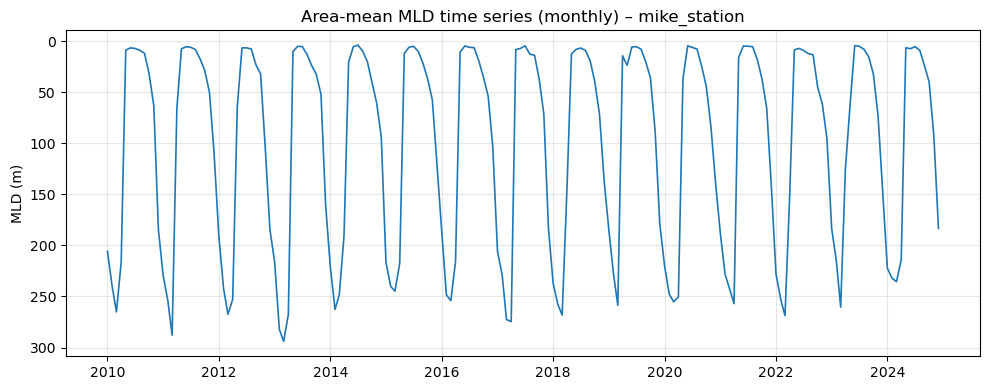

In [31]:
# ------------------------------------------------------------------
# 2. Load MLD and compute area-mean + map
# ------------------------------------------------------------------
mld_nc = DATA_RAW / f"cmems_mld_{region_name}.nc"
mld_ds = xr.open_dataset(mld_nc)

# area-average MLD over region
mld_area = mld_ds["mlotst"].mean(dim=["latitude", "longitude"], skipna=True)

# ensure time is a proper datetime index (naive OK here)
mld_area = mld_area.assign_coords(
    time=pd.to_datetime(mld_area["time"].values)
)

mld_mean_map = mld_ds["mlotst"].mean(dim="time", skipna=True)

plt.figure(figsize=(10, 4))
plt.plot(
    mld_area["time"].values,
    mld_area.values,
    lw=1.2,
)
plt.gca().invert_yaxis()  # optional
plt.grid(alpha=0.3)
plt.ylabel("MLD (m)")
plt.title(f"Area-mean MLD time series (monthly) – {region_name}")
plt.tight_layout()
plt.savefig(IMG_DIR / f"MLD_monthly_{region_name}.png", dpi=300)
plt.show()


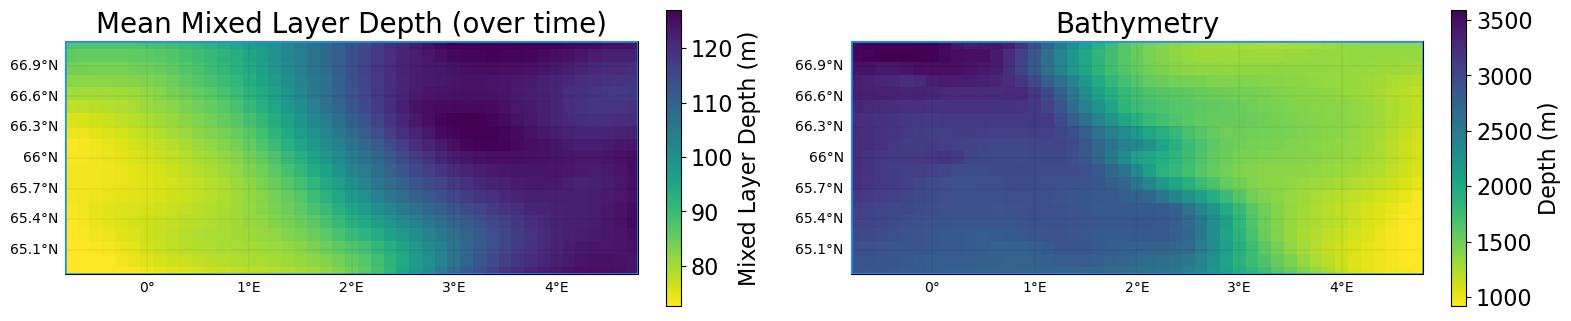

In [32]:
# ------------------------------------------------------------------
# 3. Load bathymetry and make the 2-panel map
# ------------------------------------------------------------------
bathy_nc = DATA_RAW / f"cmems_bathy_{region_name}.nc"
bathy_ds = xr.open_dataset(bathy_nc)

depth = bathy_ds["model_depth"].where(bathy_ds["model_depth"] > 0)

# Color scaling
mld_vmin   = float(mld_mean_map.quantile(0.01))
mld_vmax   = float(mld_mean_map.quantile(0.99))
bathy_vmin = float(depth.quantile(0.01))
bathy_vmax = float(depth.quantile(0.99))

proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(16, 4),
    subplot_kw={"projection": proj},
)

cmap = "viridis_r"

# Panel 1: mean MLD
ax = axes[0]
ax.set_title("Mean Mixed Layer Depth (over time)", fontsize=20)
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=":", zorder=2)

pm1 = ax.pcolormesh(
    mld_mean_map["longitude"], mld_mean_map["latitude"], mld_mean_map,
    transform=proj, cmap=cmap, shading="auto",
    vmin=mld_vmin, vmax=mld_vmax, zorder=0,
)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)

rect = Rectangle(
    (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
    linewidth=1.8, edgecolor="dodgerblue", facecolor="none",
    zorder=3, transform=proj,
)
ax.add_patch(rect)

cb1 = plt.colorbar(pm1, ax=ax, shrink=0.8, pad=0.04)
cb1.ax.tick_params(labelsize=16)
cb1.set_label("Mixed Layer Depth (m)", fontsize=16)

gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="k",
                  alpha=0.25, linestyle="--")
gl.right_labels = False
gl.top_labels = False

# Panel 2: bathymetry
ax = axes[1]
ax.set_title("Bathymetry", fontsize=20)
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=":", zorder=2)

pm2 = ax.pcolormesh(
    depth["longitude"], depth["latitude"], depth,
    transform=proj, cmap=cmap, shading="auto",
    vmin=bathy_vmin, vmax=bathy_vmax, zorder=0,
)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)

rect2 = Rectangle(
    (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
    linewidth=1.8, edgecolor="dodgerblue", facecolor="none",
    zorder=3, transform=proj,
)
ax.add_patch(rect2)

cb2 = plt.colorbar(pm2, ax=ax, shrink=0.8, pad=0.04)
cb2.ax.tick_params(labelsize=16)
cb2.set_label("Depth (m)", fontsize=16)

gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="k",
                  alpha=0.25, linestyle="--")
gl.right_labels = False
gl.top_labels = False

plt.tight_layout()
plt.savefig(IMG_DIR / f"MLD_Bathymetry_{region_name}.png", dpi=300, transparent=True)
plt.show()

In [33]:
# ------------------------------------------------------------------
# 4. Compute static h1/h2 and save as arrays
# ------------------------------------------------------------------
H_median = float(depth.median(skipna=True))
print(f"H median ≈ {H_median:.1f} m")

h1_static = float(mld_area.median(skipna=True))
h2_static = H_median - h1_static
print(f"Static h1={h1_static:.1f} m, h2={h2_static:.1f} m (H≈{H_median:.1f} m)")

h1_static_array = np.full(nt, h1_static)
h2_static_array = np.full(nt, h2_static)
delta_z_static  = 0.5 * h1_static_array + 0.5 * h2_static_array

np.savez(
    DATA_INTERIM / f"layers_static_{region_name}.npz",
    h1=h1_static_array,
    h2=h2_static_array,
    H=H_median,
    delta_z=delta_z_static,
    h1_scalar=h1_static,
    h2_scalar=h2_static,
)

print("Saved static MLD layers to", DATA_INTERIM / f"layers_static_{region_name}.npz")

H median ≈ 2384.8 m
Static h1=51.3 m, h2=2333.5 m (H≈2384.8 m)
Saved static MLD layers to C:\Users\siebert\Documents\Projekte\SEAO2CDR\rIAM\data\interim\layers_static_mike_station.npz
